### Test the Simulated Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import socket as socket
import os as os
import sys as sys
import multiprocessing as mp
import h5py
import allel
import itertools as it
import pickle as pickle

socket_name = socket.gethostname()
print(socket_name)

if socket_name.startswith("compute-"):
    print("HSM O2 Computational partition detected.")
    path = "/n/groups/reich/hringbauer/git/hapBLOCK/"  # The Path on Harvard Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")

os.chdir(path)  # Set the right Path (in line with Atom default)
sys.path.append("./python3/") 
from emission import load_emission_model
from transition import load_transition_model
from hmm import load_fwd_bwd_func
from loaddata import load_loaddata

print(os.getcwd())
print(f"CPU Count: {mp.cpu_count()}")

compute-a-17-59.o2.rc.hms.harvard.edu
HSM O2 Computational partition detected.
/n/groups/reich/hringbauer/git/hapBLOCK
CPU Count: 32


# Read the simulated data

### Load Data via the Load Object

In [2]:
l = load_loaddata(l_model="simulated", path="./output/simulated/undermodel/sim5/")
htsl, p, r_vec = l.load_all_data()

e = load_emission_model(e_model="haploid_gl")
e_mat = e.give_emission_matrix(htsl, p)
print(np.shape(e_mat))

t = load_transition_model(t_model="standard")
t.set_params(ibd_in = 0.0005, ibd_out = 0.0005, ibd_jump = 0.1, recalculate=False)
t_mat = t.full_transition_matrix(r_vec, n=4, submat33=False)
print(np.shape(t_mat))

(5, 10000)
(10000, 5, 5)


# Run Python Toy FWD-BWD

In [9]:
%%time
fwd_bwd = load_fwd_bwd_func(h_model="FiveState")
post, fwd1, bwd1, tot_ll = fwd_bwd(np.log(e_mat), t_mat, in_val = 1e-4, full=True)

Total Log likelihood fwd: -26369.094
CPU times: user 4.97 s, sys: 123 ms, total: 5.09 s
Wall time: 4.96 s


In [11]:
np.sum(np.exp(post), axis=0)

array([1., 1., 1., ..., 1., 1., 1.])

# Fast c functions

In [5]:
%%time
fwd_bwd = load_fwd_bwd_func(h_model="FiveStateFast")
post1, fwd1, bwd1, tot_ll = fwd_bwd(np.log(e_mat), t_mat, in_val = 1e-4, full=True)

Memory Usage Full:
Memory Usage: 123.346944 mB
Total Log likelihood: -26369.094
CPU times: user 44.5 ms, sys: 5.95 ms, total: 50.4 ms
Wall time: 47.4 ms


### Fast C Function low Memory

In [35]:
%%time
fwd_bwd = load_fwd_bwd_func(h_model="FiveStatLowMem")
dummy = np.zeros((1,1))
post1, fwd1, bwd1, tot_ll = fwd_bwd(np.log(e_mat), t_mat, in_val = 1e-4, full=True)

Total Log likelihood: -26831.980
Memory Usage: 142.241792 mB
CPU times: user 36.6 ms, sys: 915 µs, total: 37.5 ms
Wall time: 34.6 ms


# Plot the posterior

In [19]:
def plot_posterior(post, state=0, figsize=(12,3), c="maroon", lw=3, fs_l=12):
    """Plot Posterior [k,l] array"""
    plt.figure(figsize=figsize)
    ax=plt.gca()
    ax.plot(np.exp(post[state,:]), color=c, lw=lw)
    ax.set_xlabel("Position", fontsize=fs_l)
    ax.set_ylabel(f"Posterior State {state}", fontsize=fs_l)
    plt.show()

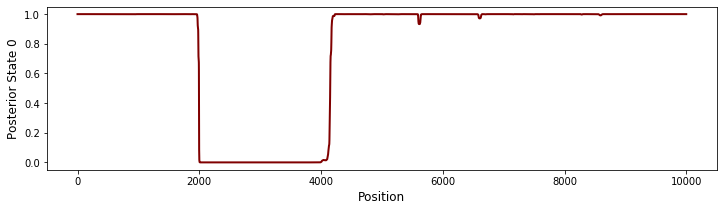

In [22]:
plot_posterior(post, state=0, lw=2, fs_l=12)

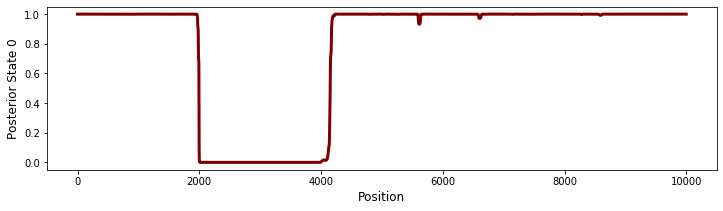

In [23]:
plot_posterior(post1, state=0, lw=3)